This file performs the pre-computation of the image embeddings of the Visual Relations Benchmark dataset. This is necessary to perform the arithmetics before prompting the LLM, but also it reduces unnecessarily computing the embeddings as only inference is performed.

### Load packages

In [1]:
import os
import pathlib
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import AutoFeatureExtractor, CLIPVisionModel

import sys
sys.path.insert(1,"..")

from fromage_inf.fromage import utils

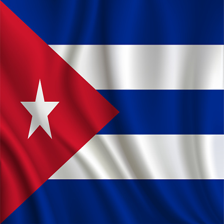

In [7]:
# image = Image.open("../benchmark/flags/cuba.jpg")
# image = image.resize((224, 224))
# image = image.convert('RGB')
# display(image)

### Load the needed models, devices and weights

In [2]:
# Set the torch device.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# Initialize some variables.
visual_embs = {}
model_name = 'openai/clip-vit-large-patch14'

# Load the feature extractor for clip.
print(f'Using HuggingFace AutoFeatureExtractor for {model_name}.')
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)

# Load the CLIP decoder for evaluation.
vis_model = CLIPVisionModel.from_pretrained(model_name, torch_dtype=torch.bfloat16)
vis_model.to(DEVICE)
vis_model.eval()
for param in vis_model.parameters():
    param.requires_grad = False

# Load the pretrained visual caption embeddings layer after CLIP.
pre = torch.load("../fromage_inf/fromage_model/pretrained_ckpt.pth.tar")
vemb_weight = pre['state_dict']['model.visual_embeddings.weight'].to(DEVICE)
vemb_bias = pre['state_dict']['model.visual_embeddings.bias'].to(DEVICE)

# As dropout during inference will be 0, do not implement this.
# image_dropout = nn.Dropout(0.0)

cuda
Using HuggingFace AutoFeatureExtractor for openai/clip-vit-large-patch14.


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPVisionModel: ['text_model.encoder.layers.4.mlp.fc1.bias', 'text_model.encoder.layers.1.layer_norm1.weight', 'text_model.encoder.layers.3.mlp.fc1.bias', 'text_model.encoder.layers.0.self_attn.k_proj.bias', 'text_model.encoder.layers.0.layer_norm2.weight', 'text_model.encoder.layers.0.layer_norm1.weight', 'text_model.encoder.layers.5.self_attn.out_proj.weight', 'text_model.encoder.layers.4.self_attn.q_proj.weight', 'text_model.encoder.layers.6.mlp.fc2.weight', 'text_model.encoder.layers.8.self_attn.q_proj.weight', 'text_model.encoder.layers.5.mlp.fc1.weight', 'text_model.encoder.layers.2.mlp.fc2.bias', 'text_model.encoder.layers.3.self_attn.q_proj.weight', 'text_model.encoder.layers.3.mlp.fc2.bias', 'text_model.encoder.layers.10.mlp.fc2.weight', 'text_model.encoder.layers.0.self_attn.out_proj.weight', 'text_model.encoder.layers.7.self_attn.v_proj.bias', 'text_model.encoder.layers.2.m

### Compute the image embeddings

In [3]:
# Load all the file names from the visual relations benchmark dataset.
images = []
for path, subdirs, files in os.walk("../benchmark/"):
    for file in files:
        #print(path)
        if file.endswith('.jpg'):
            path = pathlib.PurePath(path)
            folder = path.name
            img = folder + "/" + file
            images.append(img[:-4])
print(images)

['countries/france', 'countries/russia', 'countries/japan', 'countries/china', 'countries/egypt', 'countries/usa', 'countries/italy', 'countries/india', 'food/pizza', 'food/baguette', 'food/sushi', 'cities/cairo', 'cities/havana', 'cities/washington', 'cities/helsinki', 'cities/london', 'cities/moscow', 'cities/berlin', 'cities/bangkok', 'cities/beijing', 'cities/paris', 'cities/kabul', 'cities/canberra', 'cities/tokyo', 'leaders/hillary', 'leaders/angela_merkel', 'leaders/queen_elizabeth', 'leaders/trump', 'leaders/boris_johnson', 'leaders/putin', 'leaders/david_cameron', 'leaders/obama', 'leaders/justin_trudeau', 'leaders/xi_jinping', 'building/pyramid', 'building/kremlin', 'building/eiffle', 'building/empire_state', 'building/taj_mahal', 'building/colosseum', 'building/pisa', 'building/capitol', 'building/china_wall', 'flags/finland', 'flags/australia', 'flags/norway', 'flags/france', 'flags/england', 'flags/russia', 'flags/japan', 'flags/vietnam', 'flags/cuba', 'flags/canada', 'fla

In [4]:
# Loop all image files.
for i, img_name in enumerate(images):
    # Open and resize the image as done in the example notebook.
    img = Image.open("../benchmark/" + img_name + ".jpg")
    img = img.resize((224, 224))
    img = img.convert('RGB')

    # Retrieve the pixel values for the image.
    pixel_values = utils.get_pixel_values_for_model(feature_extractor, img)
    pixel_values = pixel_values.to(device=DEVICE, dtype=torch.bfloat16)
    pixel_values = pixel_values[None, ...]

    # Extract visual embeddings from the vision encoder given the pixel values.
    outputs = vis_model(pixel_values = pixel_values)
    encoder_outputs = outputs.pooler_output

    # Perform the linear pre-trained pass from FROMAGe after CLIP.
    visual_emb = F.linear(encoder_outputs, vemb_weight, vemb_bias) # (2, D * n_visual_tokens)
    visual_emb = torch.reshape(visual_emb, (visual_emb.shape[0], 1, -1)) # (1, n_visual_tokens, D)

    # Save the embeddings to the dictionary.
    visual_embs[img_name] = visual_emb

# Save the embeddings dictionary.
torch.save(visual_embs, "../fromage_inf/fromage_model/visual_embs.pt")

In [5]:
# Load the dictionary and check if it worked.
vis_em = torch.load("../fromage_inf/fromage_model/visual_embs.pt")
print(vis_em)

{'countries/france': tensor([[[-2.4219, -1.6016,  0.7148,  ...,  0.4961,  2.4062,  0.4707]]],
       device='cuda:0', dtype=torch.bfloat16), 'countries/russia': tensor([[[-2.9844, -0.0139,  0.1426,  ...,  0.6289,  1.9531, -0.2559]]],
       device='cuda:0', dtype=torch.bfloat16), 'countries/japan': tensor([[[-2.7344, -1.5156, -0.2363,  ..., -1.2656,  1.7734, -0.6797]]],
       device='cuda:0', dtype=torch.bfloat16), 'countries/china': tensor([[[-1.1328, -0.4844, -1.1016,  ..., -0.7266,  1.6484, -0.4766]]],
       device='cuda:0', dtype=torch.bfloat16), 'countries/egypt': tensor([[[-2.0312, -1.1172, -1.9141,  ...,  0.0664,  2.0312,  0.3555]]],
       device='cuda:0', dtype=torch.bfloat16), 'countries/usa': tensor([[[-2.3750,  0.1797,  0.4570,  ..., -1.5234, -1.0859, -0.4648]]],
       device='cuda:0', dtype=torch.bfloat16), 'countries/italy': tensor([[[-0.8828, -0.5547,  1.5000,  ...,  0.5156,  1.7031, -0.2988]]],
       device='cuda:0', dtype=torch.bfloat16), 'countries/india': tensor(